# ***Import Libarys***

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.optimizers import Adam


from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.resnet import ResNet101
from tensorflow.keras.applications import ResNet50
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import EfficientNetV2L

import random
import os
import warnings
warnings.filterwarnings('ignore')
print('compelet')

import os
import tensorflow as tf
print("Available CPU cores:", os.cpu_count())
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Set number of CPU threads for intra- and inter-op parallelism
tf.config.threading.set_intra_op_parallelism_threads(10)
tf.config.threading.set_inter_op_parallelism_threads(10)

# Optional: Force CPU usage (useful if you also have a GPU)
tf.config.set_visible_devices([], 'GPU')


/Users/shehabh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


compelet
Available CPU cores: 14
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13185834388994036860
xla_global_id: -1
]


# ***Data understanding & Visualizatio***

In [7]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Parameters
image_shape = (224, 224)
batch_size = 64
epochs = 10  # Adjust as needed
data_path = '/Users/shehabh/Downloads/new-plant-diseases-dataset'

# Paths (make sure data_path is defined)
train_folder = os.path.join(data_path, 'New Plant Diseases Dataset(Augmented)', 'New Plant Diseases Dataset(Augmented)', 'train')
valid_folder = os.path.join(data_path, 'New Plant Diseases Dataset(Augmented)', 'New Plant Diseases Dataset(Augmented)', 'valid')

# Image generators
train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load training data
print("Training Images:")
train_data = train_datagen.flow_from_directory(train_folder,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training')

# Load validation data
print("Validating Images:")
valid_data = train_datagen.flow_from_directory(train_folder,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation')

# Load test data (separate validation folder)
print("Test Images:")
test_data = test_datagen.flow_from_directory(valid_folder,
                                             target_size=image_shape,
                                             batch_size=batch_size,
                                             class_mode='categorical',
                                             shuffle=False)



Training Images:
Found 56251 images belonging to 38 classes.
Validating Images:
Found 14044 images belonging to 38 classes.
Test Images:
Found 17572 images belonging to 38 classes.


***From previous cell we know that we have 38 class***
> * 56251 images in train data
> * 14044 images in valisation data
> * 17572 images in test data
> * 33 imgeas in test data (the label of test data is the name of image) we will uses them to predict later

***But what are 38 classes ?!***

In [8]:
# show how data store
images, labels = next(iter(train_data))
print(f'shape of image is : {images[0].shape}')


shape of image is : (224, 224, 3)


In [9]:
# Show all diseases (class names) in the dataset
diseases = os.listdir(train_folder)
diseases = [f for f in diseases if not f.startswith('.')]
print(f"Diseases in dataset ({len(diseases)}):")
print(diseases)

Diseases in dataset (38):
['Strawberry___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Blueberry___healthy', 'Corn_(maize)___healthy', 'Tomato___Target_Spot', 'Peach___healthy', 'Potato___Late_blight', 'Tomato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Pepper,_bell___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Tomato___Leaf_Mold', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Cherry_(including_sour)___Powdery_mildew', 'Apple___Cedar_apple_rust', 'Tomato___Bacterial_spot', 'Grape___healthy', 'Tomato___Early_blight', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___healthy', 'Cherry_(including_sour)___healthy', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Apple___Apple_scab', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Peach___Bacterial_spot', 'Pepper,_bell___Bacterial_spot', 'Tomato___Septoria_leaf_spot', 'Squash___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot G

***We notice that we have the same plant in different class such as:***
 > * Tomato___Early_blight
 > * Tomato___Late_blight
 > * Tomato___healthy
 > * ...

***so we need to know what is the different type of plant we have***

In [10]:
# identify uniqe plant in dataset
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
print(f'number of different plants is :{len(plants)}')
print(plants)

number of different plants is :14
['Strawberry', 'Grape', 'Potato', 'Blueberry', 'Corn_(maize)', 'Tomato', 'Peach', 'Pepper,_bell', 'Orange', 'Cherry_(including_sour)', 'Apple', 'Raspberry', 'Squash', 'Soybean']


In [11]:
diseases

['Strawberry___healthy',
 'Grape___Black_rot',
 'Potato___Early_blight',
 'Blueberry___healthy',
 'Corn_(maize)___healthy',
 'Tomato___Target_Spot',
 'Peach___healthy',
 'Potato___Late_blight',
 'Tomato___Late_blight',
 'Tomato___Tomato_mosaic_virus',
 'Pepper,_bell___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Tomato___Leaf_Mold',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Cherry_(including_sour)___Powdery_mildew',
 'Apple___Cedar_apple_rust',
 'Tomato___Bacterial_spot',
 'Grape___healthy',
 'Tomato___Early_blight',
 'Corn_(maize)___Common_rust_',
 'Grape___Esca_(Black_Measles)',
 'Raspberry___healthy',
 'Tomato___healthy',
 'Cherry_(including_sour)___healthy',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Apple___Apple_scab',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Peach___Bacterial_spot',
 'Pepper,_bell___Bacterial_spot',
 'Tomato___Septoria_leaf_spot',
 'Squash___Powdery_mildew',
 'Corn_(maize)___Cercospora_leaf_

In [12]:
train_folder

'/Users/shehabh/Downloads/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'

In [13]:
os.listdir('/Users/shehabh/Downloads/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Cherry_(including_sour)___healthy')

['ecf911e8-82ab-437b-b3a9-61ee8429e3ba___JR_HL 9705_180deg.JPG',
 'c36d1d7a-7e76-4be2-a637-e544f8210db8___JR_HL 9680_flipTB.JPG',
 '91877ab2-d8bb-4743-815a-6e55e833b3b9___JR_HL 4310_180deg.JPG',
 'dbe15479-6802-4e83-850a-fff7900e0e3d___JR_HL 9854_180deg.JPG',
 '517b275d-ef1e-49b1-be9e-c7dcc95dab00___JR_HL 3988.JPG',
 '40dce93a-7697-4c0d-b37d-e3147c7ece78___JR_HL 9464_flipTB.JPG',
 '22cbfe56-85b9-4e13-8a75-faaddd496d26___JR_HL 4197_180deg.JPG',
 '9b15b47c-53e0-4873-b51c-d2b6e316d56c___JR_HL 4180.JPG',
 '743fc494-32e8-4729-af9c-679a3870922e___JR_HL 9540_180deg.JPG',
 '9e159df4-2951-459d-850a-bd822b9faf9b___JR_HL 4023_flipTB.JPG',
 'c655f45b-4c63-406c-8f6e-e3c4f9e85b06___JR_HL 9870.JPG',
 '185054fb-77dd-4c64-8d76-d1f061da173f___JR_HL 9797.JPG',
 '135f64b7-91ed-40b5-a27b-9a8a602001ec___JR_HL 9878 copy_180deg.JPG',
 'e37c34a3-b8d4-4fbd-b7a7-f0b14e4bb090___JR_HL 4294_flipTB.JPG',
 'ca1aebd1-8b31-4727-a4be-e1a8f421f1cf___JR_HL 9893 copy_flipTB.JPG',
 '14a76290-53c4-46ab-a171-7f2dbf2b13aa___JR

/Users/shehabh/Downloads/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Strawberry___healthy
/Users/shehabh/Downloads/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Grape___Black_rot
/Users/shehabh/Downloads/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Potato___Early_blight
/Users/shehabh/Downloads/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Blueberry___healthy
/Users/shehabh/Downloads/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Corn_(maize)___healthy
/Users/shehabh/Downloads/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___Target_Spot
/Users/shehabh/Downloads/new-plant-diseases-dataset/New Plant Diseases 

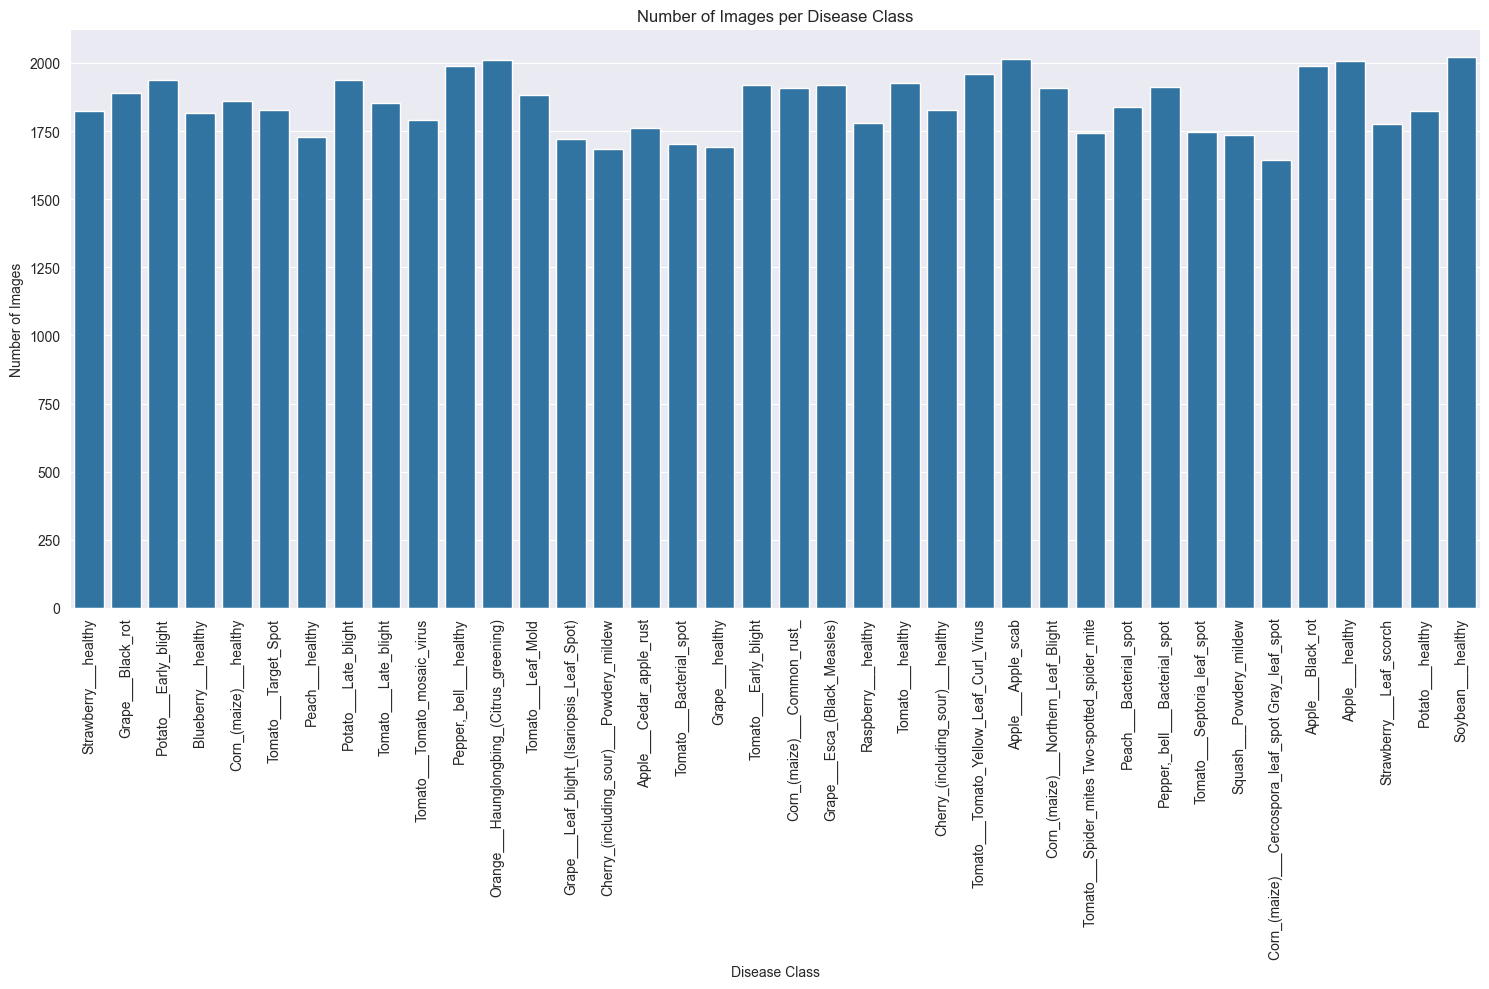

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create dictionary of class counts
dic = {}
for disease_class in diseases:
    class_path = os.path.join(train_folder, disease_class)
    print(class_path)
    dic[disease_class] = len(os.listdir(class_path))

# Convert to DataFrame
df = pd.DataFrame(list(dic.items()), columns=["Disease Class", "Number of Images"])

# Optional: sort by number of images
# df = df.sort_values(by="Number of Images", ascending=False)

# Plot
plt.figure(figsize=(15, 10))
sns.barplot(data=df, x='Disease Class', y='Number of Images')
plt.xticks(rotation=90)
plt.title("Number of Images per Disease Class")
plt.tight_layout()
plt.show()


***As we notice that classes are somewhat balanced***

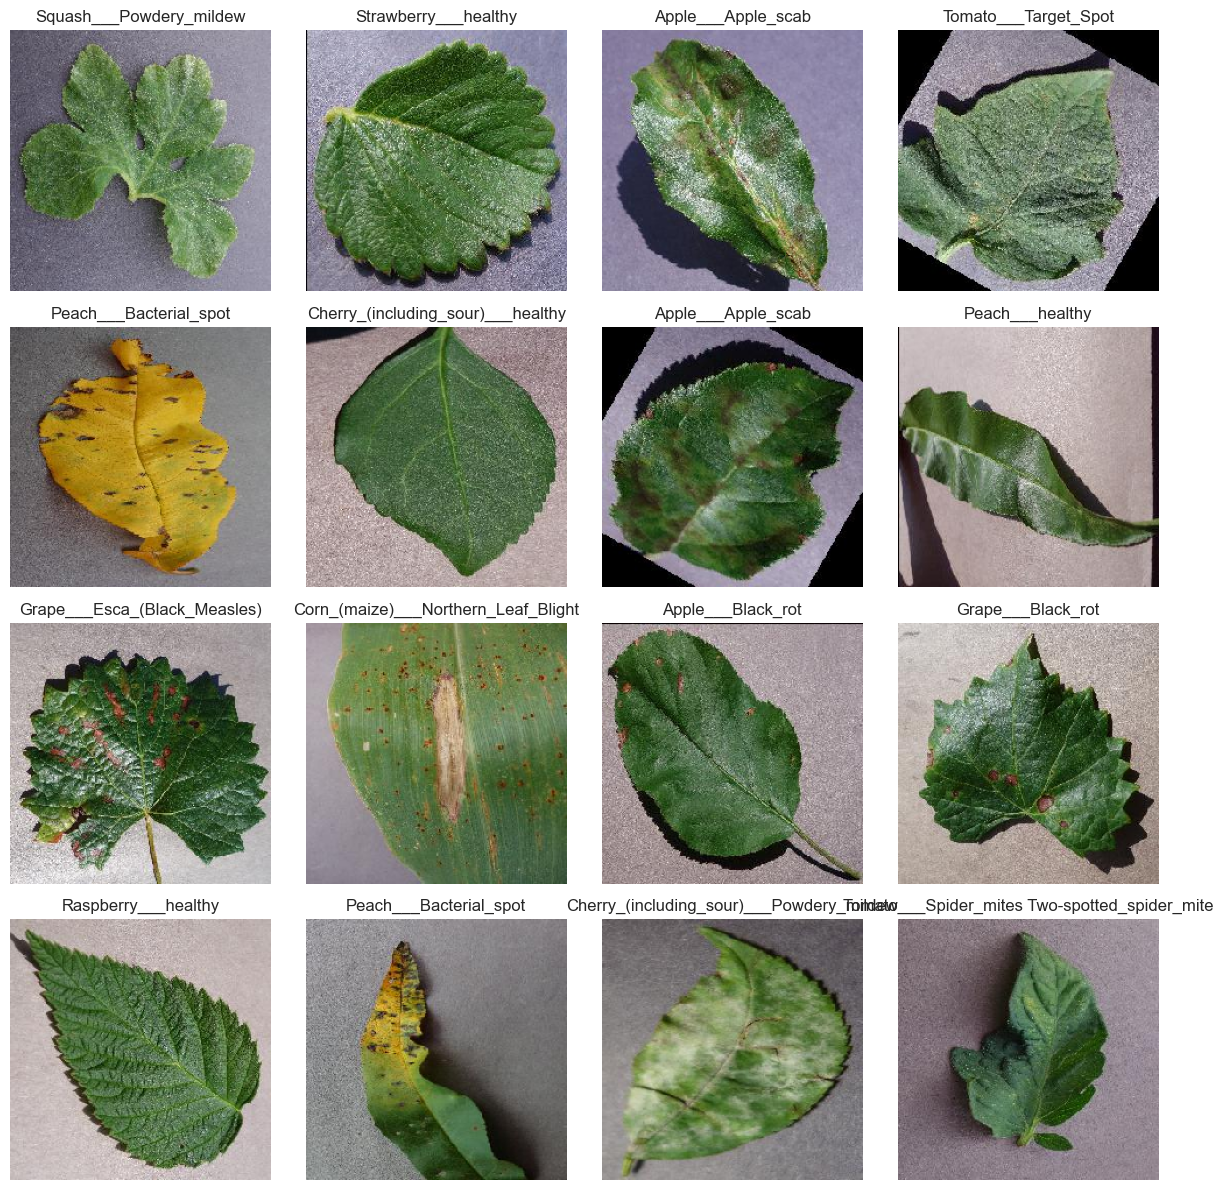

In [15]:
import random
import numpy as np

# select a specific batch
images, labels = next(iter(train_data))

# select 16 image by random
indices = random.sample(range(len(images)), 16)
selected_images = images[indices]
selected_labels = labels[indices]

class_names = list(train_data.class_indices.keys())

# plotting
plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(selected_images[i])
    plt.title(class_names[np.argmax(selected_labels[i])])
    plt.axis("off")

plt.tight_layout()
plt.show()


# ***Modeling***

***Function will be used***

Learning curve function
> * learning curve
> * loss curve

In [16]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    # accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # loss curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


Prediction function
> Compare Truth label (name of image ) with predicted label

In [17]:
def predict_labels_and_display(model_path, test_dir='/content/new-plant-diseases-dataset/test/test', image_size=(224, 224)):
    # load the best model
    best_model = load_model(model_path)

    true_labels = []
    predicted_labels = []
    images = []

    for filename in os.listdir(test_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            # load test images
            img_path = os.path.join(test_dir, filename)
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            # predict
            prediction = best_model.predict(img_array, verbose=0)
            predicted_class = np.argmax(prediction, axis=1)[0]

            # extract the label (name of image)
            true_label = filename.split('.')[0]

            # get the prediction class
            class_labels = list(train_data.class_indices.keys())
            predicted_label = class_labels[predicted_class]

            true_labels.append(true_label)
            predicted_labels.append(predicted_label)
            images.append(img)

    # randomly select three images
    selected_indices = random.sample(range(len(images)), 3)

    # show selected images
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[idx])
        plt.title(f'True: {true_labels[idx]}\nPredicted: {predicted_labels[idx]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [18]:
class_labels_ = list(train_data.class_indices.keys())
class_labels_

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

# ***CNN Model***

In [19]:
# Model Architecture
model = Sequential()

model.add(Conv2D(32,(3,3),activation = 'relu',input_shape=(224,224,3), kernel_initializer=GlorotNormal()))
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer=GlorotNormal()))
model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer=GlorotNormal()))
model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

# model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='relu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(38, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,446 (1.39 MB)

 Trainable params: 364,550 (1.39 MB)

 Non-trainable params: 896 (3.50 KB)

In [20]:
# Model Architecture
model = Sequential()

model.add(Conv2D(32,(3,3),activation = 'relu',input_shape=(224,224,3)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

# model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(38, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,446 (1.39 MB)

 Trainable params: 364,550 (1.39 MB)

 Non-trainable params: 896 (3.50 KB)

In [21]:
# from google.colab import drive
# drive.mount('/content/drive')

In [22]:
!pip install tensorflow-macos

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# train the model
model_checkpoint = ModelCheckpoint('/Users/shehabh/DriveD/DS18/projects/Plant-Diseases-Classification/content/working/cnn_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=1,
                    batch_size=64,
                    callbacks=[model_checkpoint, early_stopping])

175/879 ━━━━━━━━━━━━━━━━━━━━ 13:04 1s/step - accuracy: 0.5813 - loss: 1.3716

In [ ]:
#  save model to use later
model.save('/Users/shehabh/DriveD/DS18/projects/Plant-Diseases-Classification/content/ai_crops_model.keras')

In [ ]:
# model.save('/content/drive/My Drive/DeepLearning_CNN/ai_crops_model.keras')

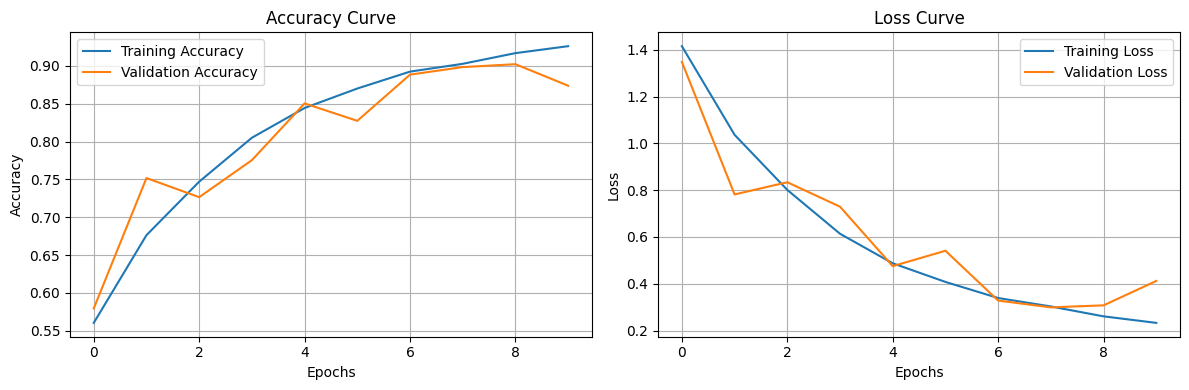

In [ ]:
plot_learning_curves(history)

In [ ]:
# best_model = load_model('/content/ai_crops_model.keras')

# best_model = load_model('/content/drive/My Drive/DeepLearning_CNN/ai_crops_model.keras')
best_model = load_model('/Users/shehabh/DriveD/DS18/projects/Plant-Diseases-Classification/content/ai_crops_model.keras')
test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.9494 - loss: 0.1560
Test Loss: 0.2179
Test Accuracy: 0.9295


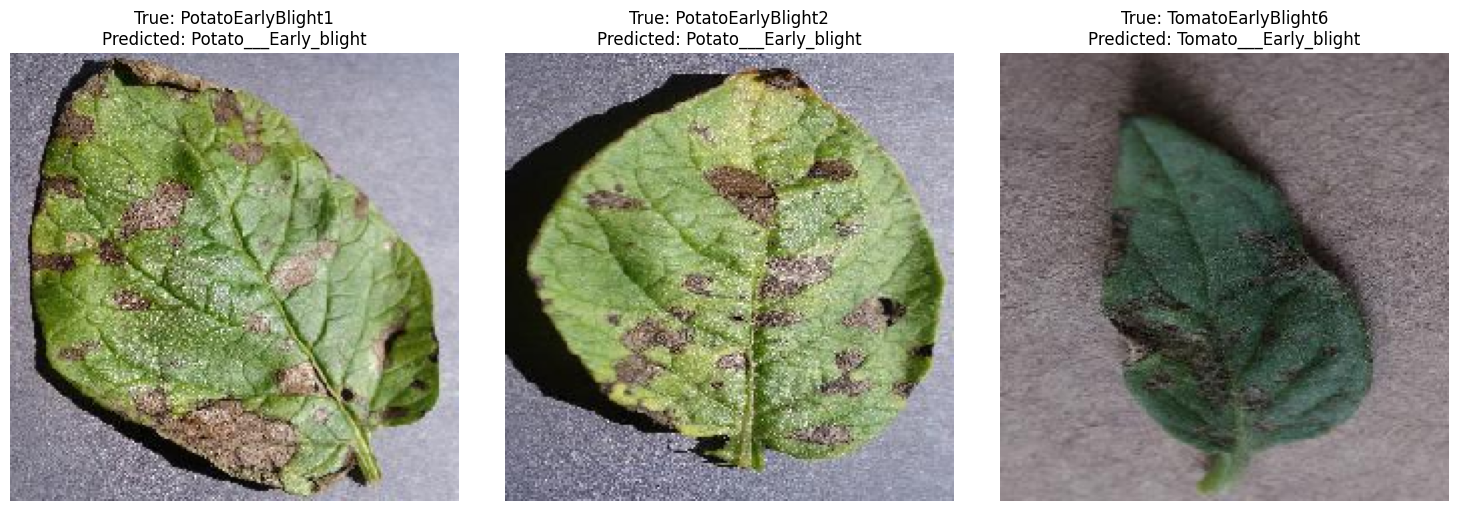

In [ ]:
# show random sample of prediction of model on test data
predict_labels_and_display('/Users/shehabh/DriveD/DS18/projects/Plant-Diseases-Classification/content/ai_crops_model.keras')